# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

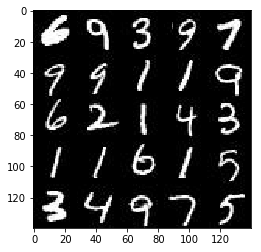

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

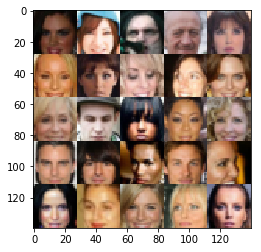

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,(None,image_width, image_height, 
                                             image_channels),name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    lr = tf.placeholder(tf.float32,name='lr')

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2, padding='same')
        h1 = tf.maximum(0.2 * h1, h1)
        #h1 = tf.nn.relu(h1)
        
        h1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.2 * h1, h1)
        #h1 = tf.nn.relu(h1)
        
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d(h1, filters=256, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.2 * h3, h3)
        
        h4 = tf.reshape(h3, [-1, 2*2*256])
        logits = tf.layers.dense(h4, 1, activation=None)
        output = tf.sigmoid(logits)
    

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, units=4*4*512)
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum( 0.2 * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, filters=128, kernel_size=4, strides=1, padding='valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, filters=64, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.2 * h3, h3)
        
        h3 = tf.layers.conv2d_transpose(h3, filters=32, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.2 * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=3, strides=1, padding='same')
        out = tf.tanh(logits)
        print(out.get_shape())
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    print(data_shape)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                i += 1
                if i % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i, epoch_count,
                                                                                       train_loss_disc, train_loss_gen ))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(60000, 28, 28, 1)
Epoch 0/2 Discriminator loss 1.2694 Generator loss 0.9929
Epoch 0/2 Discriminator loss 1.1293 Generator loss 1.2347
Epoch 0/2 Discriminator loss 1.0898 Generator loss 1.2252
Epoch 0/2 Discriminator loss 1.0527 Generator loss 1.3571
Epoch 0/2 Discriminator loss 0.9951 Generator loss 1.3578
Epoch 0/2 Discriminator loss 1.1168 Generator loss 1.1749
Epoch 0/2 Discriminator loss 1.3614 Generator loss 1.2059
Epoch 0/2 Discriminator loss 1.3770 Generator loss 0.9602
Epoch 0/2 Discriminator loss 1.4265 Generator loss 0.9245
Epoch 0/2 Discriminator loss 1.3355 Generator loss 0.8431
(?, 28, 28, 1)


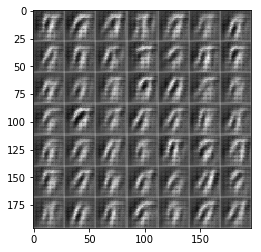

Epoch 0/2 Discriminator loss 1.3570 Generator loss 0.8331
Epoch 0/2 Discriminator loss 1.3868 Generator loss 0.8117
Epoch 0/2 Discriminator loss 1.4236 Generator loss 0.7697
Epoch 0/2 Discriminator loss 1.3889 Generator loss 0.7951
Epoch 0/2 Discriminator loss 1.3657 Generator loss 0.8107
Epoch 0/2 Discriminator loss 1.3582 Generator loss 0.8098
Epoch 0/2 Discriminator loss 1.3529 Generator loss 0.8102
Epoch 0/2 Discriminator loss 1.3693 Generator loss 0.8067
Epoch 0/2 Discriminator loss 1.3852 Generator loss 0.7953
Epoch 0/2 Discriminator loss 1.3620 Generator loss 0.8038
(?, 28, 28, 1)


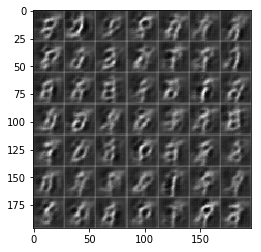

Epoch 0/2 Discriminator loss 1.4050 Generator loss 0.8000
Epoch 0/2 Discriminator loss 1.3958 Generator loss 0.7643
Epoch 0/2 Discriminator loss 1.3888 Generator loss 0.7771
Epoch 0/2 Discriminator loss 1.4020 Generator loss 0.7639
Epoch 0/2 Discriminator loss 1.3932 Generator loss 0.7899
Epoch 0/2 Discriminator loss 1.3979 Generator loss 0.7879
Epoch 0/2 Discriminator loss 1.4080 Generator loss 0.7632
Epoch 0/2 Discriminator loss 1.4026 Generator loss 0.7623
Epoch 0/2 Discriminator loss 1.4233 Generator loss 0.7701
Epoch 0/2 Discriminator loss 1.3994 Generator loss 0.7597
(?, 28, 28, 1)


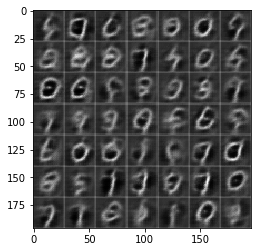

Epoch 0/2 Discriminator loss 1.3793 Generator loss 0.7746
Epoch 0/2 Discriminator loss 1.4048 Generator loss 0.7827
Epoch 0/2 Discriminator loss 1.3782 Generator loss 0.7864
Epoch 0/2 Discriminator loss 1.3771 Generator loss 0.7751
Epoch 0/2 Discriminator loss 1.3915 Generator loss 0.7663
Epoch 0/2 Discriminator loss 1.3994 Generator loss 0.7700
Epoch 0/2 Discriminator loss 1.3888 Generator loss 0.7775
Epoch 0/2 Discriminator loss 1.3776 Generator loss 0.7893
Epoch 0/2 Discriminator loss 1.3870 Generator loss 0.7688
Epoch 0/2 Discriminator loss 1.3918 Generator loss 0.7694
(?, 28, 28, 1)


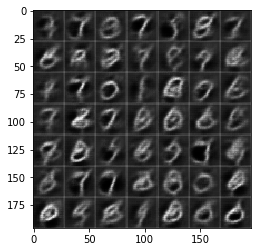

Epoch 0/2 Discriminator loss 1.3988 Generator loss 0.7463
Epoch 0/2 Discriminator loss 1.4015 Generator loss 0.7526
Epoch 0/2 Discriminator loss 1.3818 Generator loss 0.7892
Epoch 0/2 Discriminator loss 1.3880 Generator loss 0.7626
Epoch 0/2 Discriminator loss 1.3937 Generator loss 0.7421
Epoch 0/2 Discriminator loss 1.3864 Generator loss 0.7499
Epoch 0/2 Discriminator loss 1.3922 Generator loss 0.7913
Epoch 0/2 Discriminator loss 1.3913 Generator loss 0.7617
Epoch 0/2 Discriminator loss 1.3853 Generator loss 0.7774
Epoch 0/2 Discriminator loss 1.3894 Generator loss 0.7973
(?, 28, 28, 1)


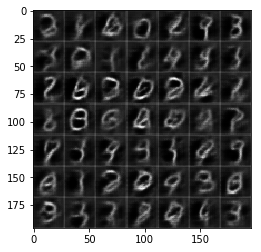

Epoch 0/2 Discriminator loss 1.3821 Generator loss 0.7609
Epoch 0/2 Discriminator loss 1.3803 Generator loss 0.7820
Epoch 0/2 Discriminator loss 1.3865 Generator loss 0.7567
Epoch 0/2 Discriminator loss 1.3949 Generator loss 0.7488
Epoch 0/2 Discriminator loss 1.3986 Generator loss 0.7381
Epoch 0/2 Discriminator loss 1.3861 Generator loss 0.7792
Epoch 0/2 Discriminator loss 1.3711 Generator loss 0.7834
Epoch 0/2 Discriminator loss 1.3945 Generator loss 0.8007
Epoch 0/2 Discriminator loss 1.3871 Generator loss 0.8205
Epoch 0/2 Discriminator loss 1.3794 Generator loss 0.8440
(?, 28, 28, 1)


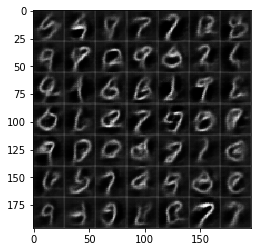

Epoch 0/2 Discriminator loss 1.3849 Generator loss 0.8461
Epoch 0/2 Discriminator loss 1.3887 Generator loss 0.8064
Epoch 0/2 Discriminator loss 1.3788 Generator loss 0.7879
Epoch 0/2 Discriminator loss 1.3867 Generator loss 0.7480
Epoch 0/2 Discriminator loss 1.3801 Generator loss 0.7482
Epoch 0/2 Discriminator loss 1.3652 Generator loss 0.7792
Epoch 0/2 Discriminator loss 1.3720 Generator loss 0.7804
Epoch 0/2 Discriminator loss 1.3825 Generator loss 0.7870
Epoch 0/2 Discriminator loss 1.3834 Generator loss 0.8237
Epoch 0/2 Discriminator loss 1.3885 Generator loss 0.8115
(?, 28, 28, 1)


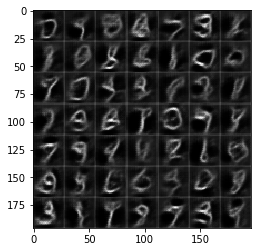

Epoch 0/2 Discriminator loss 1.3839 Generator loss 0.8322
Epoch 0/2 Discriminator loss 1.3850 Generator loss 0.7818
Epoch 0/2 Discriminator loss 1.3925 Generator loss 0.7355
Epoch 0/2 Discriminator loss 1.3666 Generator loss 0.7619
Epoch 0/2 Discriminator loss 1.3709 Generator loss 0.7665
Epoch 0/2 Discriminator loss 1.3758 Generator loss 0.7733
Epoch 0/2 Discriminator loss 1.3645 Generator loss 0.8127
Epoch 0/2 Discriminator loss 1.3648 Generator loss 0.7947
Epoch 0/2 Discriminator loss 1.3782 Generator loss 0.7378
Epoch 0/2 Discriminator loss 1.3723 Generator loss 0.7444
(?, 28, 28, 1)


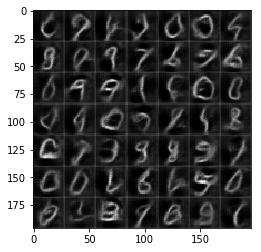

Epoch 0/2 Discriminator loss 1.3955 Generator loss 0.7224
Epoch 0/2 Discriminator loss 1.3757 Generator loss 0.7554
Epoch 0/2 Discriminator loss 1.3641 Generator loss 0.7754
Epoch 0/2 Discriminator loss 1.3642 Generator loss 0.8176
Epoch 0/2 Discriminator loss 1.3758 Generator loss 0.8756
Epoch 0/2 Discriminator loss 1.3727 Generator loss 0.8715
Epoch 0/2 Discriminator loss 1.3868 Generator loss 0.8538
Epoch 0/2 Discriminator loss 1.3651 Generator loss 0.8339
Epoch 0/2 Discriminator loss 1.3687 Generator loss 0.8533
Epoch 0/2 Discriminator loss 1.3855 Generator loss 0.8364
(?, 28, 28, 1)


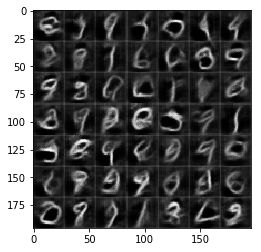

Epoch 0/2 Discriminator loss 1.3649 Generator loss 0.7551
Epoch 0/2 Discriminator loss 1.3720 Generator loss 0.7612
Epoch 0/2 Discriminator loss 1.3658 Generator loss 0.7828
Epoch 1/2 Discriminator loss 1.3869 Generator loss 0.7560
Epoch 1/2 Discriminator loss 1.3696 Generator loss 0.7687
Epoch 1/2 Discriminator loss 1.3698 Generator loss 0.8462
Epoch 1/2 Discriminator loss 1.3697 Generator loss 0.8157
Epoch 1/2 Discriminator loss 1.3733 Generator loss 0.7842
Epoch 1/2 Discriminator loss 1.3686 Generator loss 0.7906
Epoch 1/2 Discriminator loss 1.3729 Generator loss 0.7371
(?, 28, 28, 1)


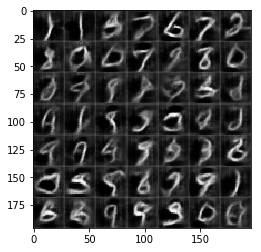

Epoch 1/2 Discriminator loss 1.3661 Generator loss 0.7555
Epoch 1/2 Discriminator loss 1.3723 Generator loss 0.7561
Epoch 1/2 Discriminator loss 1.3705 Generator loss 0.7492
Epoch 1/2 Discriminator loss 1.3762 Generator loss 0.7401
Epoch 1/2 Discriminator loss 1.3659 Generator loss 0.7699
Epoch 1/2 Discriminator loss 1.3695 Generator loss 0.7995
Epoch 1/2 Discriminator loss 1.3819 Generator loss 0.7721
Epoch 1/2 Discriminator loss 1.3756 Generator loss 0.7992
Epoch 1/2 Discriminator loss 1.3856 Generator loss 0.9027
Epoch 1/2 Discriminator loss 1.3808 Generator loss 0.8713
(?, 28, 28, 1)


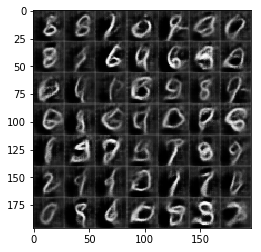

Epoch 1/2 Discriminator loss 1.3675 Generator loss 0.8308
Epoch 1/2 Discriminator loss 1.3801 Generator loss 0.7827
Epoch 1/2 Discriminator loss 1.3639 Generator loss 0.7819
Epoch 1/2 Discriminator loss 1.3717 Generator loss 0.7360
Epoch 1/2 Discriminator loss 1.3744 Generator loss 0.7469
Epoch 1/2 Discriminator loss 1.3766 Generator loss 0.8119
Epoch 1/2 Discriminator loss 1.3735 Generator loss 0.8355
Epoch 1/2 Discriminator loss 1.3695 Generator loss 0.8420
Epoch 1/2 Discriminator loss 1.3775 Generator loss 0.8070
Epoch 1/2 Discriminator loss 1.3760 Generator loss 0.8127
(?, 28, 28, 1)


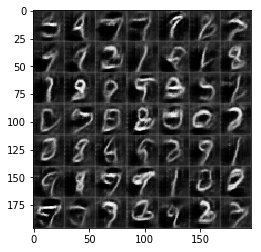

Epoch 1/2 Discriminator loss 1.3627 Generator loss 0.8127
Epoch 1/2 Discriminator loss 1.3761 Generator loss 0.8658
Epoch 1/2 Discriminator loss 1.3805 Generator loss 0.8379
Epoch 1/2 Discriminator loss 1.3686 Generator loss 0.8388
Epoch 1/2 Discriminator loss 1.3619 Generator loss 0.8265
Epoch 1/2 Discriminator loss 1.3738 Generator loss 0.8671
Epoch 1/2 Discriminator loss 1.3645 Generator loss 0.7974
Epoch 1/2 Discriminator loss 1.3891 Generator loss 0.7563
Epoch 1/2 Discriminator loss 1.3756 Generator loss 0.7502
Epoch 1/2 Discriminator loss 1.3528 Generator loss 0.7754
(?, 28, 28, 1)


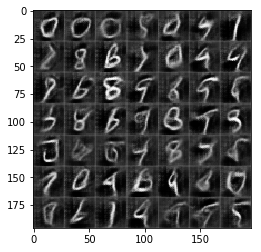

Epoch 1/2 Discriminator loss 1.3710 Generator loss 0.7640
Epoch 1/2 Discriminator loss 1.3799 Generator loss 0.7866
Epoch 1/2 Discriminator loss 1.3723 Generator loss 0.7915
Epoch 1/2 Discriminator loss 1.3642 Generator loss 0.7951
Epoch 1/2 Discriminator loss 1.3778 Generator loss 0.7587
Epoch 1/2 Discriminator loss 1.3716 Generator loss 0.7446
Epoch 1/2 Discriminator loss 1.3748 Generator loss 0.7899
Epoch 1/2 Discriminator loss 1.3690 Generator loss 0.8219
Epoch 1/2 Discriminator loss 1.3734 Generator loss 0.8026
Epoch 1/2 Discriminator loss 1.3752 Generator loss 0.7468
(?, 28, 28, 1)


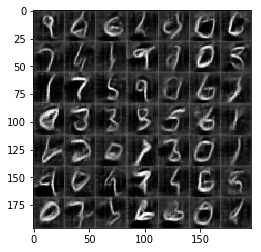

Epoch 1/2 Discriminator loss 1.3846 Generator loss 0.7132
Epoch 1/2 Discriminator loss 1.3787 Generator loss 0.7274
Epoch 1/2 Discriminator loss 1.3685 Generator loss 0.7536
Epoch 1/2 Discriminator loss 1.3819 Generator loss 0.7689
Epoch 1/2 Discriminator loss 1.3706 Generator loss 0.7546
Epoch 1/2 Discriminator loss 1.3770 Generator loss 0.7643
Epoch 1/2 Discriminator loss 1.3873 Generator loss 0.7475
Epoch 1/2 Discriminator loss 1.3779 Generator loss 0.7751
Epoch 1/2 Discriminator loss 1.3713 Generator loss 0.7731
Epoch 1/2 Discriminator loss 1.3655 Generator loss 0.7664
(?, 28, 28, 1)


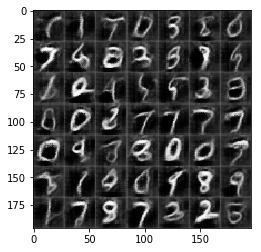

Epoch 1/2 Discriminator loss 1.3704 Generator loss 0.7785
Epoch 1/2 Discriminator loss 1.3759 Generator loss 0.7768
Epoch 1/2 Discriminator loss 1.3791 Generator loss 0.7352
Epoch 1/2 Discriminator loss 1.3807 Generator loss 0.7345
Epoch 1/2 Discriminator loss 1.3847 Generator loss 0.7418
Epoch 1/2 Discriminator loss 1.3789 Generator loss 0.7629
Epoch 1/2 Discriminator loss 1.3748 Generator loss 0.8137
Epoch 1/2 Discriminator loss 1.3772 Generator loss 0.8351
Epoch 1/2 Discriminator loss 1.3697 Generator loss 0.8554
Epoch 1/2 Discriminator loss 1.3789 Generator loss 0.8091
(?, 28, 28, 1)


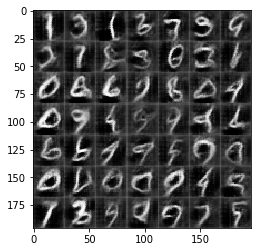

Epoch 1/2 Discriminator loss 1.3756 Generator loss 0.7465
Epoch 1/2 Discriminator loss 1.3792 Generator loss 0.7748
Epoch 1/2 Discriminator loss 1.3752 Generator loss 0.7855
Epoch 1/2 Discriminator loss 1.3776 Generator loss 0.7638
Epoch 1/2 Discriminator loss 1.3809 Generator loss 0.7064
Epoch 1/2 Discriminator loss 1.3803 Generator loss 0.7408
Epoch 1/2 Discriminator loss 1.3624 Generator loss 0.7781
Epoch 1/2 Discriminator loss 1.3696 Generator loss 0.7652
Epoch 1/2 Discriminator loss 1.3736 Generator loss 0.8094
Epoch 1/2 Discriminator loss 1.3761 Generator loss 0.7979
(?, 28, 28, 1)


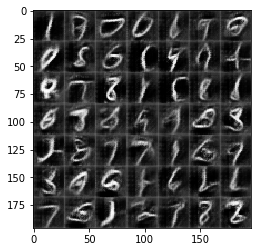

Epoch 1/2 Discriminator loss 1.3683 Generator loss 0.8348
Epoch 1/2 Discriminator loss 1.3698 Generator loss 0.8522
Epoch 1/2 Discriminator loss 1.3893 Generator loss 0.8612
Epoch 1/2 Discriminator loss 1.3748 Generator loss 0.7934
Epoch 1/2 Discriminator loss 1.3849 Generator loss 0.7714
Epoch 1/2 Discriminator loss 1.3701 Generator loss 0.8181
Epoch 1/2 Discriminator loss 1.3730 Generator loss 0.7980
Epoch 1/2 Discriminator loss 1.3732 Generator loss 0.7569
Epoch 1/2 Discriminator loss 1.3773 Generator loss 0.7365
Epoch 1/2 Discriminator loss 1.3555 Generator loss 0.7672
(?, 28, 28, 1)


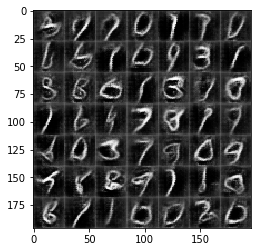

Epoch 1/2 Discriminator loss 1.3773 Generator loss 0.7689
Epoch 1/2 Discriminator loss 1.3696 Generator loss 0.7927
Epoch 1/2 Discriminator loss 1.3810 Generator loss 0.8353
Epoch 1/2 Discriminator loss 1.3781 Generator loss 0.7731
Epoch 1/2 Discriminator loss 1.3741 Generator loss 0.7539
Epoch 1/2 Discriminator loss 1.3745 Generator loss 0.7689
Epoch 1/2 Discriminator loss 1.3733 Generator loss 0.7928


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(202599, 28, 28, 3)
Epoch 0/1 Discriminator loss 1.4616 Generator loss 1.0498
Epoch 0/1 Discriminator loss 1.5608 Generator loss 1.0962
Epoch 0/1 Discriminator loss 1.2666 Generator loss 1.0313
Epoch 0/1 Discriminator loss 1.2523 Generator loss 1.0071
Epoch 0/1 Discriminator loss 1.1628 Generator loss 1.0449
Epoch 0/1 Discriminator loss 1.1518 Generator loss 1.0379
Epoch 0/1 Discriminator loss 1.0700 Generator loss 1.1028
Epoch 0/1 Discriminator loss 1.3535 Generator loss 1.2114
Epoch 0/1 Discriminator loss 1.0998 Generator loss 1.2044
Epoch 0/1 Discriminator loss 1.2172 Generator loss 1.1798
(?, 28, 28, 3)


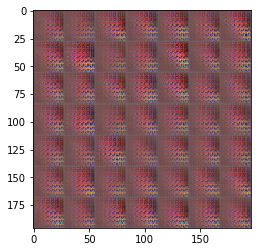

Epoch 0/1 Discriminator loss 1.4742 Generator loss 1.1152
Epoch 0/1 Discriminator loss 1.3488 Generator loss 0.8337
Epoch 0/1 Discriminator loss 1.3403 Generator loss 0.8626
Epoch 0/1 Discriminator loss 1.3261 Generator loss 0.8817
Epoch 0/1 Discriminator loss 1.3229 Generator loss 0.8959
Epoch 0/1 Discriminator loss 1.3279 Generator loss 0.8623
Epoch 0/1 Discriminator loss 1.3416 Generator loss 0.8463
Epoch 0/1 Discriminator loss 1.3779 Generator loss 0.8220
Epoch 0/1 Discriminator loss 1.3934 Generator loss 0.7978
Epoch 0/1 Discriminator loss 1.3968 Generator loss 0.8215
(?, 28, 28, 3)


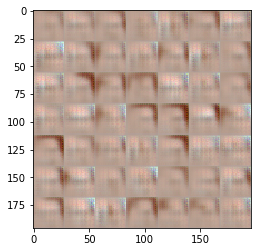

Epoch 0/1 Discriminator loss 1.4035 Generator loss 0.8019
Epoch 0/1 Discriminator loss 1.3686 Generator loss 0.8064
Epoch 0/1 Discriminator loss 1.3956 Generator loss 0.8291
Epoch 0/1 Discriminator loss 1.3744 Generator loss 0.7908
Epoch 0/1 Discriminator loss 1.3878 Generator loss 0.8004
Epoch 0/1 Discriminator loss 1.3991 Generator loss 0.8085
Epoch 0/1 Discriminator loss 1.3940 Generator loss 0.8298
Epoch 0/1 Discriminator loss 1.3625 Generator loss 0.8192
Epoch 0/1 Discriminator loss 1.3785 Generator loss 0.8156
Epoch 0/1 Discriminator loss 1.3759 Generator loss 0.8256
(?, 28, 28, 3)


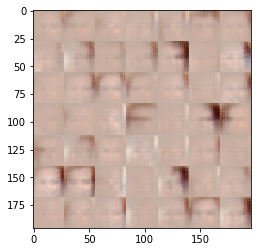

Epoch 0/1 Discriminator loss 1.3711 Generator loss 0.8080
Epoch 0/1 Discriminator loss 1.3886 Generator loss 0.7761
Epoch 0/1 Discriminator loss 1.3902 Generator loss 0.7853
Epoch 0/1 Discriminator loss 1.3966 Generator loss 0.7951
Epoch 0/1 Discriminator loss 1.3711 Generator loss 0.7962
Epoch 0/1 Discriminator loss 1.4062 Generator loss 0.7766
Epoch 0/1 Discriminator loss 1.7005 Generator loss 0.9037
Epoch 0/1 Discriminator loss 1.3766 Generator loss 0.7772
Epoch 0/1 Discriminator loss 1.3807 Generator loss 0.8075
Epoch 0/1 Discriminator loss 1.3998 Generator loss 0.7871
(?, 28, 28, 3)


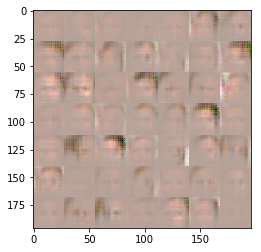

Epoch 0/1 Discriminator loss 1.3714 Generator loss 0.7966
Epoch 0/1 Discriminator loss 1.3910 Generator loss 0.7765
Epoch 0/1 Discriminator loss 1.3894 Generator loss 0.7998
Epoch 0/1 Discriminator loss 1.3878 Generator loss 0.7880
Epoch 0/1 Discriminator loss 1.3812 Generator loss 0.7911
Epoch 0/1 Discriminator loss 1.3769 Generator loss 0.8019
Epoch 0/1 Discriminator loss 1.3892 Generator loss 0.7908
Epoch 0/1 Discriminator loss 1.3801 Generator loss 0.7874
Epoch 0/1 Discriminator loss 1.3817 Generator loss 0.7868
Epoch 0/1 Discriminator loss 1.3806 Generator loss 0.7810
(?, 28, 28, 3)


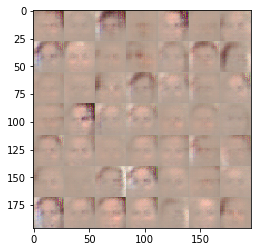

Epoch 0/1 Discriminator loss 1.3836 Generator loss 0.7849
Epoch 0/1 Discriminator loss 1.3848 Generator loss 0.7885
Epoch 0/1 Discriminator loss 1.3781 Generator loss 0.7966
Epoch 0/1 Discriminator loss 1.3894 Generator loss 0.7889
Epoch 0/1 Discriminator loss 1.3826 Generator loss 0.7820
Epoch 0/1 Discriminator loss 1.3882 Generator loss 0.7824
Epoch 0/1 Discriminator loss 1.3797 Generator loss 0.7835
Epoch 0/1 Discriminator loss 1.3760 Generator loss 0.7985
Epoch 0/1 Discriminator loss 1.3800 Generator loss 0.7888
Epoch 0/1 Discriminator loss 1.3870 Generator loss 0.7886
(?, 28, 28, 3)


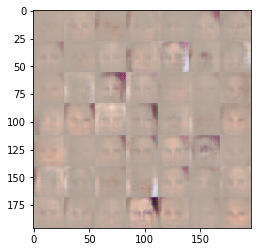

Epoch 0/1 Discriminator loss 1.3872 Generator loss 0.7906
Epoch 0/1 Discriminator loss 1.3802 Generator loss 0.7929
Epoch 0/1 Discriminator loss 1.3727 Generator loss 0.7956
Epoch 0/1 Discriminator loss 1.3801 Generator loss 0.7790
Epoch 0/1 Discriminator loss 1.3842 Generator loss 0.7862
Epoch 0/1 Discriminator loss 1.3834 Generator loss 0.8055
Epoch 0/1 Discriminator loss 1.4014 Generator loss 0.8132
Epoch 0/1 Discriminator loss 1.3733 Generator loss 0.8055
Epoch 0/1 Discriminator loss 1.3867 Generator loss 0.7757
Epoch 0/1 Discriminator loss 1.3804 Generator loss 0.7826
(?, 28, 28, 3)


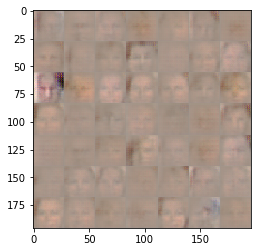

Epoch 0/1 Discriminator loss 1.3774 Generator loss 0.7864
Epoch 0/1 Discriminator loss 1.3768 Generator loss 0.7847
Epoch 0/1 Discriminator loss 1.3867 Generator loss 0.7884
Epoch 0/1 Discriminator loss 1.4016 Generator loss 0.7978
Epoch 0/1 Discriminator loss 1.4024 Generator loss 0.7933
Epoch 0/1 Discriminator loss 1.3829 Generator loss 0.7828
Epoch 0/1 Discriminator loss 1.3759 Generator loss 0.7969
Epoch 0/1 Discriminator loss 1.3860 Generator loss 0.7958
Epoch 0/1 Discriminator loss 1.3942 Generator loss 0.7865
Epoch 0/1 Discriminator loss 1.3909 Generator loss 0.7839
(?, 28, 28, 3)


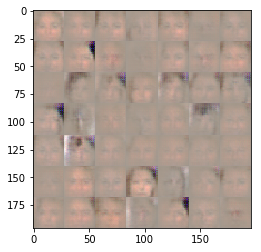

Epoch 0/1 Discriminator loss 1.3808 Generator loss 0.7931
Epoch 0/1 Discriminator loss 1.3802 Generator loss 0.7922
Epoch 0/1 Discriminator loss 1.3756 Generator loss 0.8070
Epoch 0/1 Discriminator loss 1.3908 Generator loss 0.7993
Epoch 0/1 Discriminator loss 1.3864 Generator loss 0.7960
Epoch 0/1 Discriminator loss 1.3814 Generator loss 0.7913
Epoch 0/1 Discriminator loss 1.3846 Generator loss 0.7990
Epoch 0/1 Discriminator loss 1.3800 Generator loss 0.7995
Epoch 0/1 Discriminator loss 1.3804 Generator loss 0.7870
Epoch 0/1 Discriminator loss 1.3832 Generator loss 0.8007
(?, 28, 28, 3)


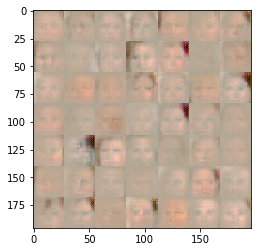

Epoch 0/1 Discriminator loss 1.3773 Generator loss 0.7963
Epoch 0/1 Discriminator loss 1.3845 Generator loss 0.8018
Epoch 0/1 Discriminator loss 1.3891 Generator loss 0.7893
Epoch 0/1 Discriminator loss 2.1637 Generator loss 1.2327
Epoch 0/1 Discriminator loss 1.3873 Generator loss 0.7950
Epoch 0/1 Discriminator loss 1.3764 Generator loss 0.8059
Epoch 0/1 Discriminator loss 1.3909 Generator loss 0.8013
Epoch 0/1 Discriminator loss 1.3967 Generator loss 0.8114
Epoch 0/1 Discriminator loss 1.3817 Generator loss 0.7964
Epoch 0/1 Discriminator loss 1.3744 Generator loss 0.7963
(?, 28, 28, 3)


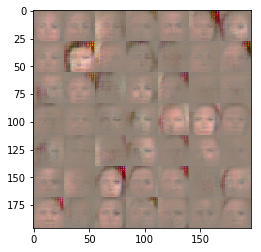

Epoch 0/1 Discriminator loss 1.3756 Generator loss 0.7829
Epoch 0/1 Discriminator loss 1.3765 Generator loss 0.7913
Epoch 0/1 Discriminator loss 1.3798 Generator loss 0.7890
Epoch 0/1 Discriminator loss 1.3797 Generator loss 0.7838
Epoch 0/1 Discriminator loss 1.4008 Generator loss 0.8056
Epoch 0/1 Discriminator loss 1.3824 Generator loss 0.7992
Epoch 0/1 Discriminator loss 1.3783 Generator loss 0.8020
Epoch 0/1 Discriminator loss 1.3852 Generator loss 0.7961
Epoch 0/1 Discriminator loss 1.3836 Generator loss 0.7845
Epoch 0/1 Discriminator loss 1.3786 Generator loss 0.7975
(?, 28, 28, 3)


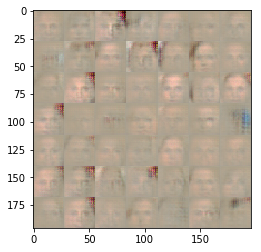

Epoch 0/1 Discriminator loss 1.3801 Generator loss 0.7847
Epoch 0/1 Discriminator loss 1.3835 Generator loss 0.7924
Epoch 0/1 Discriminator loss 1.3783 Generator loss 0.7974
Epoch 0/1 Discriminator loss 1.3815 Generator loss 0.7902
Epoch 0/1 Discriminator loss 1.3912 Generator loss 0.7946
Epoch 0/1 Discriminator loss 1.3798 Generator loss 0.7876
Epoch 0/1 Discriminator loss 1.3776 Generator loss 0.7970
Epoch 0/1 Discriminator loss 1.3819 Generator loss 0.8048
Epoch 0/1 Discriminator loss 1.3872 Generator loss 0.8089
Epoch 0/1 Discriminator loss 1.3848 Generator loss 0.7919
(?, 28, 28, 3)


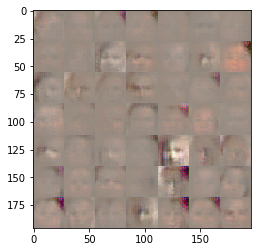

Epoch 0/1 Discriminator loss 1.3825 Generator loss 0.7841
Epoch 0/1 Discriminator loss 1.3789 Generator loss 0.7880
Epoch 0/1 Discriminator loss 1.3805 Generator loss 0.7908
Epoch 0/1 Discriminator loss 1.3770 Generator loss 0.8013
Epoch 0/1 Discriminator loss 1.3813 Generator loss 0.8001
Epoch 0/1 Discriminator loss 1.3793 Generator loss 0.7921
Epoch 0/1 Discriminator loss 1.3816 Generator loss 0.7800
Epoch 0/1 Discriminator loss 1.3838 Generator loss 0.7899
Epoch 0/1 Discriminator loss 1.3820 Generator loss 0.8031
Epoch 0/1 Discriminator loss 1.3833 Generator loss 0.7809
(?, 28, 28, 3)


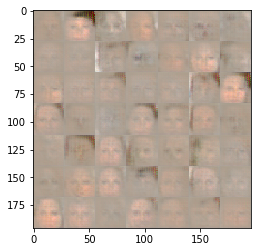

Epoch 0/1 Discriminator loss 1.3808 Generator loss 0.7869
Epoch 0/1 Discriminator loss 1.3854 Generator loss 0.7936
Epoch 0/1 Discriminator loss 1.3832 Generator loss 0.7862
Epoch 0/1 Discriminator loss 1.3784 Generator loss 0.7881
Epoch 0/1 Discriminator loss 1.3857 Generator loss 0.7892
Epoch 0/1 Discriminator loss 1.3790 Generator loss 0.7868
Epoch 0/1 Discriminator loss 1.3875 Generator loss 0.7896
Epoch 0/1 Discriminator loss 1.3866 Generator loss 0.7868
Epoch 0/1 Discriminator loss 1.3853 Generator loss 0.7939
Epoch 0/1 Discriminator loss 1.3858 Generator loss 0.7850
(?, 28, 28, 3)


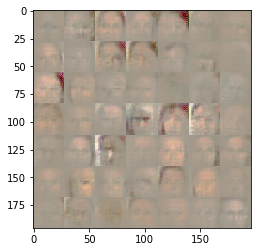

Epoch 0/1 Discriminator loss 1.3872 Generator loss 0.7886
Epoch 0/1 Discriminator loss 1.3797 Generator loss 0.8001
Epoch 0/1 Discriminator loss 1.3787 Generator loss 0.7965
Epoch 0/1 Discriminator loss 1.3872 Generator loss 0.7790
Epoch 0/1 Discriminator loss 1.3852 Generator loss 0.7927
Epoch 0/1 Discriminator loss 1.3835 Generator loss 0.7836
Epoch 0/1 Discriminator loss 1.3825 Generator loss 0.7930
Epoch 0/1 Discriminator loss 1.3908 Generator loss 0.7715
Epoch 0/1 Discriminator loss 1.3824 Generator loss 0.7913
Epoch 0/1 Discriminator loss 1.3789 Generator loss 0.7914
(?, 28, 28, 3)


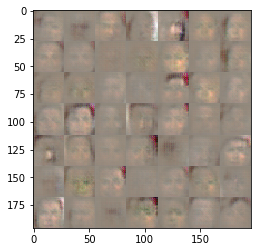

Epoch 0/1 Discriminator loss 1.3774 Generator loss 0.7907
Epoch 0/1 Discriminator loss 1.3848 Generator loss 0.7863
Epoch 0/1 Discriminator loss 1.3823 Generator loss 0.7903
Epoch 0/1 Discriminator loss 1.3798 Generator loss 0.7944
Epoch 0/1 Discriminator loss 1.3792 Generator loss 0.7812
Epoch 0/1 Discriminator loss 1.3797 Generator loss 0.7870
Epoch 0/1 Discriminator loss 1.3821 Generator loss 0.7954
Epoch 0/1 Discriminator loss 1.3819 Generator loss 0.7806


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.